In [1]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation
)
import geopandas as gpd
import matplotlib.pyplot as plt
import pathlib

In [2]:
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH/ "Documents"/ "Automating GIS" / "Poland_income_2022"

In [3]:
# Uploading counties shapefile and csv with income data for year 2022
counties = gpd.read_file(DATA_DIRECTORY/ "counties_pow.shp", encoding='windows-1250')
income = pd.read_csv(DATA_DIRECTORY / "income_a.csv", encoding='utf-8')

In [4]:
# Renaming column with codes that are unique for each county as it will be used below in removing duplicates process
counties = counties.rename(columns={'JPT_NAZWA_':'Nazwa','JPT_KOD_JE':'KOD'})

In [25]:
# Due to the fact, that some polish counties are having the same name, but they belong to different voivodeships, there are some duplicates in the data in the column
# storing county names. In order to match correctly counties and income data based on the county names, duplicates must be removed.
# Csv file with income data was updated with the voivodeship name in brackets per each duplicated value. Counties shapefile data are updated in the code below.

# Searching for duplicates
duplicates = counties[counties.duplicated('Nazwa', keep=False)]
print(duplicates)

Empty GeoDataFrame
Columns: [gml_id, JPT_SJR_KO, JPT_POWIER, KOD, Nazwa, JPT_ORGAN_, JPT_JOR_ID, WERSJA_OD, WERSJA_DO, WAZNY_OD, WAZNY_DO, JPT_KOD__1, JPT_NAZWA1, JPT_ORGAN1, JPT_WAZNA_, ID_BUFORA_, ID_BUFORA1, ID_TECHNIC, IIP_PRZEST, IIP_IDENTY, IIP_WERSJA, JPT_KJ_IIP, JPT_KJ_I_1, JPT_KJ_I_2, JPT_OPIS, JPT_SPS_KO, ID_BUFOR_1, JPT_ID, JPT_POWI_1, JPT_KJ_I_3, JPT_GEOMET, JPT_GEOM_1, SHAPE_LENG, SHAPE_AREA, REGON, RODZAJ, ID, geometry]
Index: []

[0 rows x 38 columns]


In [6]:
# Updating duplicates based on the county codes provided here: https://pl.wikisource.org/wiki/Polskie_powiaty_wed%C5%82ug_kodu_TERYT 

counties.loc[(counties['KOD'] == '1807'), 'Nazwa'] = 'powiat krośnieński (podkarpacki)'
counties.loc[(counties['KOD'] == '0802'), 'Nazwa'] = 'powiat krośnieński (lubuski)'
counties.loc[(counties['KOD'] == '2003'), 'Nazwa'] = 'powiat bielski (podlaski)'
counties.loc[(counties['KOD'] == '2402'), 'Nazwa'] = 'powiat bielski (śląski)'
counties.loc[(counties['KOD'] == '1202'), 'Nazwa'] = 'powiat brzeski (małopolski)'
counties.loc[(counties['KOD'] == '1601'), 'Nazwa'] = 'powiat brzeski (opolski)'
counties.loc[(counties['KOD'] == '1405'), 'Nazwa'] = 'powiat grodziski (mazowiecki)'
counties.loc[(counties['KOD'] == '3005'), 'Nazwa'] = 'powiat grodziski (wielkopolski)'
counties.loc[(counties['KOD'] == '0218'), 'Nazwa'] = 'powiat średzki (dolnośląski)'
counties.loc[(counties['KOD'] == '3025'), 'Nazwa'] = 'powiat średzki (wielkopolski)'
counties.loc[(counties['KOD'] == '1609'), 'Nazwa'] = 'powiat opolski (opolski)'
counties.loc[(counties['KOD'] == '0612'), 'Nazwa'] = 'powiat opolski (lubelski)'
counties.loc[(counties['KOD'] == '1416'), 'Nazwa'] = 'powiat ostrowski (mazowiecki)'
counties.loc[(counties['KOD'] == '3017'), 'Nazwa'] = 'powiat ostrowski (wielkopolski)'
counties.loc[(counties['KOD'] == '2210'), 'Nazwa'] = 'powiat nowodworski (pomorski)'
counties.loc[(counties['KOD'] == '1414'), 'Nazwa'] = 'powiat nowodworski (mazowiecki)'
counties.loc[(counties['KOD'] == '0617'), 'Nazwa'] = 'powiat świdnicki (lubelski)'
counties.loc[(counties['KOD'] == '0219'), 'Nazwa'] = 'powiat świdnicki (dolnośląski)'
counties.loc[(counties['KOD'] == '0618'), 'Nazwa'] = 'powiat tomaszowski (lubelski)'
counties.loc[(counties['KOD'] == '1016'), 'Nazwa'] = 'powiat tomaszowski (łódzki)'

In [7]:
# Merging income data and counties shapefile based on the county name
income_2022 = pd.merge(counties, income, left_on=counties['Nazwa'].str.lower(), right_on=income['Nazwa'].str.lower(), how='left', indicator=False)

income_2022_fixed

In [26]:
# Moran's I
# The Moran’s I statistic is the correlation coefficient for the relationship between a variable (here: income) and its neighboring values.
# Before computing the correlation, the neighbour must be defined. As the counties of Poland are considered, let's define a neighbour as any polygon
# that is sharing at least the common vertex of the border (Queen contiguity).

# Creating the spatial weights matrix using queen contiguity
w = weights.Queen.from_dataframe(income_2022, ids="KOD")

In [9]:
# Searching for islands (for the purpose of calculating spatial autocorrelation islands must been taken into account as they could have an influence
# on the results.)
w.islands

[]

In [10]:
# Standardising the spatial weights matrix using row-standardize method to make sure every row of the matrix sums up to one
w.transform = 'R'

In [12]:
# Income values must be transformed to float type in order to process standarisation
income_2022['2022'] = income_2022['2022'].str.replace(',','.').astype(float)

# Standardising income substracting the average value and dividing by the standard deviation each observation of the column
income_2022['income_stand'] = ((income_2022['2022'] - income_2022['2022'].mean()) / income_2022['2022'].std())

In [13]:
# Creating spatial lag
income_2022['w_income_stand'] = weights.lag_spatial(w, income_2022['income_stand'])

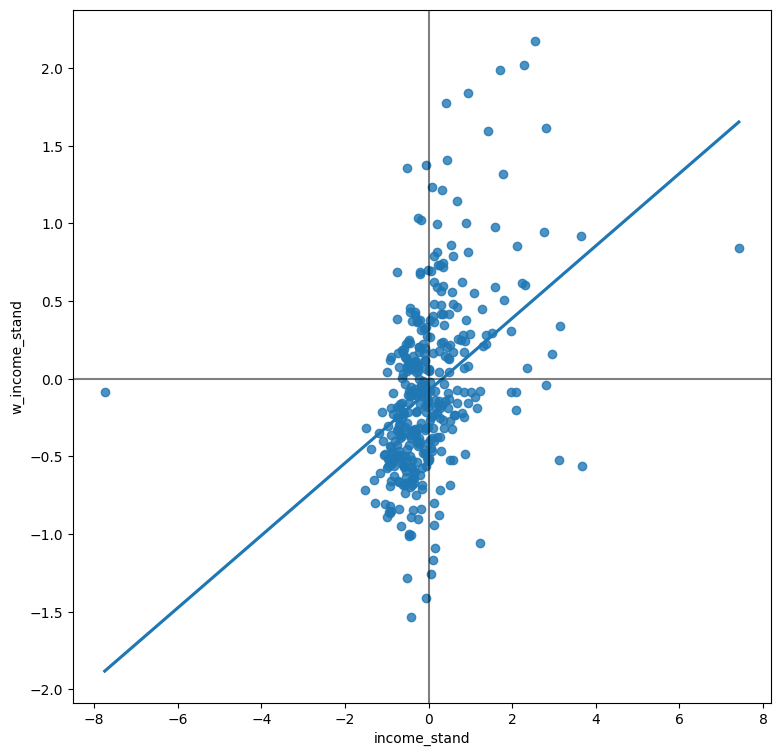

In [16]:
# GLOBAL SPATIAL AUTOCORRELATION

# MORAN PLOT
# The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation.
# It is presented as scatter plot in which the variable of interest is displayed against its spatial lag.

# In order to be able to interpret values below the mean, or their quantities in terms of standard deviations, the variable of interest is standardized.

fig, ax = plt.subplots(1, figsize=(9,9))

# Plotting the values
sns.regplot(x='income_stand', y='w_income_stand', data=income_2022, ci=None)

# Adding vertical and horizontal lines
plt.axvline(0, color='k', alpha=0.5)
plt.axhline(0, color='k', alpha=0.5)
plt.show()

In [27]:
# Moran's I
# Although the Moran Plot enables to explore the data and notice how much values are clustered over space, some statistical measure that summarizes the figure
# could help understand more the specificity of autocorrelation. It can be achieved by using Moran's I.

# A specific function in PySAL enables to calculate Moran's I in the given dataset:
# Note: standardized version is not used as we do not represent it visually.
# Note: the value of Moran’s I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.
mi = esda.Moran(income_2022['2022'], w)
mi.I

0.23304687628875906

In [19]:
# The other bit of information that can be extracted from Moran’s I relates to statistical inference: how likely is the pattern 
# we observe in the map and Moran’s I captures in its value to be generated by an entirely random process? 

# A small enough p-value associated with the Moran’s I of a map allows to reject the hypothesis that the map is random:
# the map displays more spatial pattern that we would expect if the values had been randomly allocated to a particular location.

# P-value can be checked using the following function:
mi.p_sim

0.001

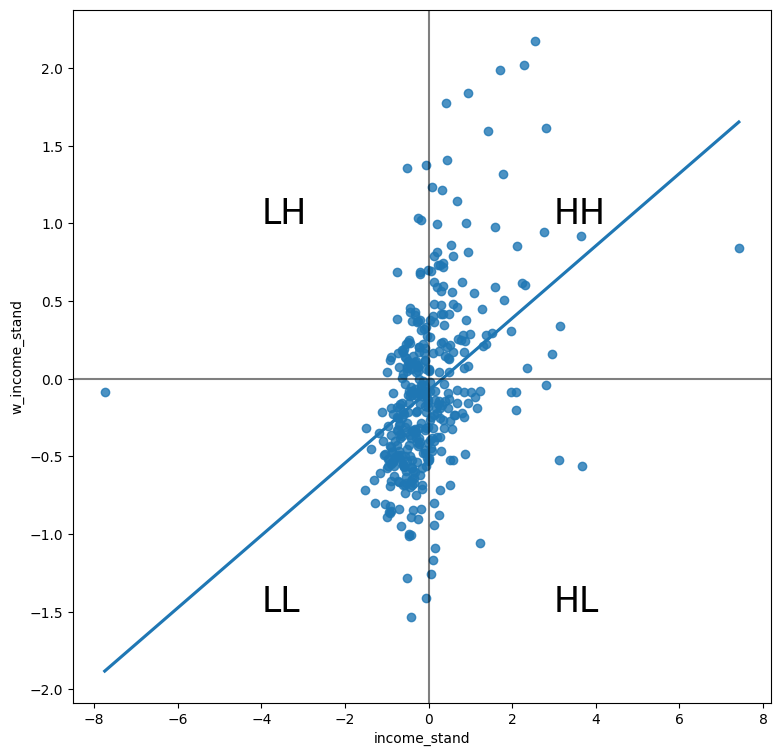

In [20]:
# LOCAL SPATAL AUTOCORRELATION

# Moran’s I tool help to summarizes a dataset into a single value that informs about its degree of clustering
# and can tell us values are clustered overall. However it will not inform us about where specific values are located.
# For that purpose, alocal measure of spatial autocorrelation must be used.

# Local measures consider each single observation in a dataset and operate on them, as oposed to on the overall data, as global measures do. 

# LISAs [Local Indicators of Spatial Association] - a local counter-part of global measures like Moran’s I 
# The core of these method is a classification of the observations in a dataset into four groups derived from the Moran Plot: 
# high values surrounded by high values (HH), low values nearby other low values (LL), high values among low values (HL), and viceversa (LH). 
# Each of these groups are typically called “quadrants”.

fig, ax = plt.subplots(1, figsize=(9,9))

# Plotting the data
sns.regplot(x='income_stand', y='w_income_stand', data=income_2022, ci=None)

# Plotting vertical and horizontal lines
plt.axvline(0, c='black', alpha=0.5)
plt.axhline(0, c='black', alpha=0.5)

# Adding quadrants
plt.text(3, 1, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-4, 1, "LH", fontsize=25)
plt.text(-4, -1.5, "LL", fontsize=25)

# Display
plt.show()

In [21]:
# To determine if specific locations form statistically significant clusters of a certain type, 
# we must compare their arrangement with what we'd anticipate if the data were randomly distributed. 
# While every observation naturally falls into one category or another, our focus lies in assessing whether the intensity of value concentration is unusually high. 
#LISAs (Local Indicators of Spatial Association) are specifically designed for this purpose, helping us evaluate the significance of spatial patterns 
# in the strength of observed values.

# The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors 
# is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar 
# to the one in the global Moran’s I, but applied in this case to each observation, resulting then in as many statistics as original observations.

# LISAs can be calculated in a very streamlined way using PySAL:
lisa = esda.Moran_Local(income_2022['2022'], w)

In [22]:
# Due to their inherent nature, merely examining the numerical outcomes of LISAs might not be the most effective means of fully utilizing the information they offer 
# as we're computing a statistic for each individual observation in the dataset. When dealing with a large number of observations, extracting meaningful patterns 
# can be challenging. Instead, a common approach is to generate a map, often referred to as a cluster map. 
# This map highlights the significant observations—those highly improbable to result from random chance—and represents them using distinctive colors corresponding 
# to their quadrant category. This visual representation allows for a clearer interpretation of spatial patterns.

# Break observations into significant or not (with 5% selected as the threshold for statistical significance)
income_2022['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
income_2022['quadrant'] = lisa.q

(<Figure size 640x480 with 1 Axes>, <Axes: >)

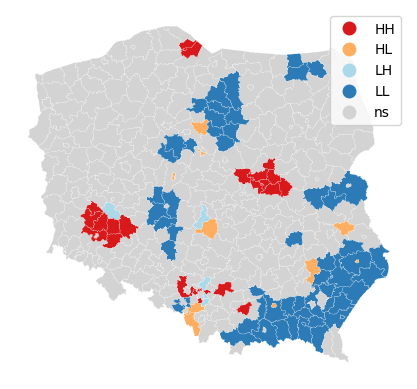

In [23]:
# With these two elements, significant and quadrant, a typical LISA cluster map can be built

# Creating LISA cluster map with splot:
lisa_cluster(lisa, income_2022)